In [21]:
!pip install -qU "semantic-router[local]"


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
PROJECT_PATH = "../cargo"
PROJECT_NAME = "cargo"
GROQ_API_KEY = "youapikey"

In [23]:
from llama_index.agent.openai import OpenAIAgent
from llama_index.llms.groq import Groq
from llama_index.core.tools import FunctionTool
from semantic_router import Route
from semantic_router.encoders import HuggingFaceEncoder
from semantic_router.layer import RouteLayer
from IPython.display import Markdown
from ema_workbench import load_results
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.cluster.hierarchy as sch
from sklearn_extra.cluster import KMedoids
import pickle
import seaborn as sns
from typing import Union

In [24]:
class DecompositionSpace:
    def __init__(self, project_path, project_name):
        model_filename = f"{project_path}/{project_name}_128scenarios_nopolicies_sobol" #.tar.gz'
        experiments_df, outcomes = load_results(model_filename+ '.tar.gz')
        self.outcomes = pd.DataFrame(outcomes)
        self.experiments = experiments_df
        self.all = pd.concat([experiments_df, self.outcomes], axis=1)
        self.all.index = self.all.apply(lambda row: f"resolution_{row['resolution']}_k_{row['k']}", axis=1)
        with open(model_filename+'_model.pkl', 'rb') as input:
            self.uncertainties_problem = pickle.load(input)
        with open(model_filename+'_partitions.pkl', 'rb') as input:
            self.partitions = pickle.load(input)
        similarity_filename = f"{project_path}/{project_name}_omega_scores.csv"
        self.partitions_distance = 1 - pd.read_csv(similarity_filename, index_col=0)
        stable_solutions_filename = f"{project_path}/{project_name}_stable_solutions.pkl"
        with open(stable_solutions_filename, 'rb') as f:
             self.stable_solutions = pickle.load(f)
             self.other_labels = self.stable_solutions.keys()
             self.all['stability'] = 0
             for index, value in self.stable_solutions.items():
                 self.all.loc[index, 'stability'] = value
        mds = MDS(dissimilarity='precomputed', random_state=0)
        self.embeddings_2d_partitions = mds.fit_transform(self.partitions_distance)
        partition_labels_2d, _, silhouette = self.run_agglomerative(self.embeddings_2d_partitions, k=5, threshold=None,
                                                       show_dendogram=True, normalize=True, n_pca=2)
        self.partition_labels = partition_labels_2d

    def run_agglomerative(self, df, k, threshold=200, n_pca=None, normalize=False, show_dendogram=False, archstructure=None):
      if normalize:
        sample = StandardScaler().fit_transform(df)
      else:
        sample = df.values

      if n_pca is not None:
        pca = PCA(n_components=n_pca)
        sample_pca = sample
        model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward',
                                        connectivity=archstructure, distance_threshold=threshold)
        model.fit(sample_pca)
        X = sample_pca
      else:
        model = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='single',
                                      connectivity=archstructure, distance_threshold=threshold)
        model.fit(sample)
      labels = model.labels_
      fixed_labels = np.where(model.labels_ < 0, 0, model.labels_)
      classes = set(fixed_labels)
      if len(classes) > 1:
        if n_pca is not None:
          silhouette = metrics.silhouette_score(sample_pca, fixed_labels)
        else:
          silhouette = metrics.silhouette_score(sample, fixed_labels)
      else:
        silhouette = 0.0
      return fixed_labels, model, silhouette

    def get_decompositions_by_metric(self, metric: str, k: int, asc: bool) -> list:
        return self.all.sort_values(by=[metric], ascending=[asc]).head(k)

    def get_stable_solutions(self, k: int, asc: bool) -> list:
        pass

    def get_xy_coordinates(self, labels, embeddings_2d, distance_df):
        xy_coordinates = []
        for lb in labels:
            idx = list(distance_df.columns).index(lb)
            xy_coordinates.append(embeddings_2d[idx])
        return xy_coordinates

    def get_decomposition_space(self, labels: [] = []) -> plt.plot:
        fig = plt.figure(figsize=(8,6))
        df = pd.DataFrame(self.embeddings_2d_partitions, columns=['x', 'y'])
        df['cluster'] = self.partition_labels
        ax = sns.scatterplot(data=df, x="x", y="y", hue="cluster", palette="tab10", alpha=0.3, legend='full', sizes=(20, 200))
        ax.set(xlabel=None)
        ax.set(ylabel=None)
        if len(labels) > 0:
            medoids = np.array(self.get_xy_coordinates(labels, self.embeddings_2d_partitions, self.partitions_distance))
            ax.plot(medoids[:,0], medoids[:,1], 'X', markersize=9, alpha=0.7, color='black')
            for idx, lb in enumerate(labels):
                    ax.annotate(lb, (medoids[idx,0], medoids[idx,1]))

        plt.grid(False)
        return plt

    #TODO translate/map quality attributes to metrics

In [25]:
class SemanticLayer:
    SYSTEM_PROMPT = """Your are an expert software architect that assists users to explore and understand a de.
        You have a deep understanding of monolith to microservices migration and microservices quality metrics.
        Your role is to help users to understand the decomposition space to pick the most suitable microservices decomposition according to the user need.
        """

    def __init__(self, decomposition_space=None) -> None:
        self.llm = Groq(model="llama3-groq-70b-8192-tool-use-preview", api_key=GROQ_API_KEY, base_url="https://api.groq.com/openai/v1")
        self.agent = None
        self.intent_detector = None
        self.decomposition_space = decomposition_space


    def get_decomposition_space(self) -> plt.plot:
        """ Get the decomposition space graphically.

        Returns:
            plt.plot: The plot of the decomposition space
        """
        return self.decomposition_space.get_decomposition_space().show()

    def get_decomposition_by_metric(self, k: int, metric: str, asc: bool, show_plot: bool) -> Union[pd.DataFrame, plt.plot]:
        """ Get the K decompositions that match a preferring metric (ned, density, modularity, stability, or n_partitions)).

          Args:
            k (int): The number of decompositions to retrieve.
            metric (str): The metric to match the decompositions against, one of ned, density, modularity, stability, or number of partitions (n_partitions).
            asc (bool): Whether to prefer lower values (True) or higher values (False).
            show_plot (bool): Whether to return the decompositions that match a metric graphically through a plot

        Returns:
            pd.DataFrame: The K decompositions ordered by asc param against the metric passed as parameter.
        """
        decompositions = self.decomposition_space.get_decompositions_by_metric(metric, k, asc)
        if show_plot:
            indexes = decompositions.index.values
            return self.decomposition_space.get_decomposition_space(decompositions.index.values).show()
        return decompositions


    def _get_tools(self):
        return [ # All the functions that the agent can execute
            FunctionTool.from_defaults(fn=self.get_decomposition_space, return_direct=True),
            FunctionTool.from_defaults(fn=self.get_decomposition_by_metric, return_direct=True)
        ]

    def _configure_routes():
        return [
            Route(
                name="get_decomposition_space",
                utterances=[
                    "Which decompositions are generated?",
                    "Show me the decomposition space graphically",
                    "Get all decompositions graphically",
                    "Show me all decompositions",
                    "Show the decomposition space",
                    "Show the decomposition space graphically"
                ],
                description="Get the decomposition space graphically."
            ),
            Route(
                name="get_decomposition_by_metric",
                utterances=[
                    "Get the X decompositions with less Y",
                    "Get me X decompositions with more Y",
                    "Which is the decomposition with more X?",
                    "Which is the decomposition with less X?",
                    "Which is the decomposition of highest X?",
                    "Which is the decomposition of lowest X?",
                    "Show me the decomposition with more X",
                    "Get a plot of the decomposition X",
                    "Show me the decomposition with more X graphically",
                    "Show me the decomposition with lowest X graphically",
                    "Show me the decomposition with highest X graphically",
                    "Show me the decomposition of lowest X graphically",
                    "Show me the decomposition of highest X graphically",
                ],
                description="Get the K decompositions that match a preferring metric, graphically or raw."
            )
        ]

    def clear_memory(self):
        self.agent.reset()

    def chat(self, question, return_intent=False):
        if self.agent is None:
            tools = self._get_tools()
            self.agent = OpenAIAgent.from_tools(tools, llm=self.llm, system_prompt=SemanticLayer.SYSTEM_PROMPT, verbose=not return_intent)
            encoder = HuggingFaceEncoder()
            self.intent_detector = RouteLayer(encoder=encoder, routes=SemanticLayer._configure_routes(), llm=self.llm)

        intent  = self.intent_detector(question)
        print("Intent detected:", intent.name)

        if intent.name is None:
            msg = "I'm sorry, I did not understand your question or I'm no able to answer it. Please try again..."
            if return_intent:
                return None
            return display(Markdown(f"<b>{msg}</b>"))

        function_name = "\nTry to execute tool "+intent.name if (intent.name is not None) and (intent.name != 'misc') else ""
        response = self.agent.chat(question+function_name)

        if return_intent:
            return intent.name, response.sources[0].raw_input.get("kwargs"), response
        else:

            if response.sources is None or len(response.sources) == 0:
                return display(Markdown(f"<b>{response.response}</b>"))

            obj = response.sources[0].raw_output

            show_op = getattr(obj, "show", None)
            if callable(show_op):
                msg =  "This is a graphical representation of the results for your question."
                display(Markdown(f"<b>{msg}</b>"))
                show_op()
                return None
            return obj

In [26]:
decomposition_space = DecompositionSpace(PROJECT_PATH, PROJECT_NAME)

C:\Users\ana\AppData\Local\Temp\ipykernel_17636\548869190.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.99609375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.all.loc[index, 'stability'] = value
C:\Users\ana\AppData\Local\pypoetry\Cache\virtualenvs\microminer-eval-xJeYZYLB-py3.9\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
C:\Users\ana\AppData\Local\pypoetry\Cache\virtualenvs\microminer-eval-xJeYZYLB-py3.9\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


# Evaluation

In [27]:
from llama_index.core.evaluation import DatasetGenerator, RelevancyEvaluator
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex, Response
from llama_index.core import Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.tools import FunctionTool
from llama_index.core.schema import Document
from llama_index.core.prompts.base import BasePromptTemplate, PromptTemplate

In [28]:
Settings.llm = Groq(model="llama3-groq-70b-8192-tool-use-preview", api_key=GROQ_API_KEY, base_url="https://api.groq.com/openai/v1")
Settings.embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-small-en-v1.5"
)
import nest_asyncio

nest_asyncio.apply()

In [29]:
DEFAULT_TEXT_QA_PROMPT = """\
Context information is below.
You are an expert software architect that assists users to explore and understand a decomposition space.
You have a deep understanding of monolith to microservices migration and microservices quality metrics.
Your role is to help users to understand the decomposition space to pick the most suitable microservices decomposition according to the user needs.
The only available metrics are ned, density, modularity, stability, and number of partitions (n_partitions)
Just answer with the questions and answers in a Q: A: format, nothing else
---------------------
{context_str}
---------------------
Based on the following function documentation, generate natural questions that someone might ask and this function answer.
Be explicit of whether you want our not graphical representation.
The answer should always be the function name along its arguments indicating args names.
The questions should relate to its description and expected outcomes in a conversational manner, also to the example questions.
Do not include args not listed in the function documentation.
If based on the documentation a function can not be used to answer the question, return an empty string ("").
The documentation is as follows:
{query_str}
"""
text_question_template = PromptTemplate(DEFAULT_TEXT_QA_PROMPT)
text_qa_template = DEFAULT_TEXT_QA_PROMPT
question_gen_query = (f"You are a Teacher/Professor. Your task is to setup \
                        just 15 questions for an upcoming \
                        quiz/examination. The questions should be diverse in nature \
                            across the document. Restrict the questions to the \
                                context information provided. Tip: use the example questions as inspiration" )

In [30]:
documentation = [Document(text="""
                Function: get_decomposition_space
                Example questions:  "Which decompositions are generated?",
                    "Show me the decomposition space graphically",
                    "Get all decompositions graphically",
                    "Show me all decompositions",
                    "Show the decomposition space",
                    "Show the decomposition space graphically"
                Description: Get the decomposition space graphically.
                Returns:
                    plt.plot: The plot of the decomposition space
            """), Document(text="""
                Function: get_decomposition_by_metric
                Example questions:  "Get the X decompositions with less Y",
                    "Get me X decompositions with more Y",
                    "Which is the decomposition with more X?",
                    "Which is the decomposition with less X?",
                    "Which is the decomposition of highest X?",
                    "Which is the decomposition of lowest X?",
                Description: Get the K decompositions that match a preferring metric (ned, density, modularity, stability, or n_partitions)).
                Args:
                    k (int): The number of decompositions to retrieve.
                    metric (str): The metric to match the decompositions against.
                    asc (bool): Whether to prefer lower values (True) or higher values (False).
                    show_plot (bool): Whether to return the decompositions that match a metric graphically through a plot.
            Returns:
                pd.DataFrame: The K decompositions ordered by asc param against the metric passed as parameter.
            """)]

In [31]:
data_generator = DatasetGenerator.from_documents(documentation, text_question_template=text_question_template, text_qa_template=text_qa_template, question_gen_query=question_gen_query)
questions = data_generator.generate_questions_from_nodes()

C:\Users\ana\AppData\Local\pypoetry\Cache\virtualenvs\microminer-eval-xJeYZYLB-py3.9\lib\site-packages\llama_index\core\evaluation\dataset_generation.py:200: DeprecationWarning: Call to deprecated class DatasetGenerator. (Deprecated in favor of `RagDatasetGenerator` which should be used instead.)
  return cls(
C:\Users\ana\AppData\Local\pypoetry\Cache\virtualenvs\microminer-eval-xJeYZYLB-py3.9\lib\site-packages\llama_index\core\evaluation\dataset_generation.py:296: DeprecationWarning: Call to deprecated class QueryResponseDataset. (Deprecated in favor of `LabelledRagDataset` which should be used instead.)
  return QueryResponseDataset(queries=queries, responses=responses_dict)


In [32]:
questions

['Q: What is the decomposition space of a monolith to microservices migration?',
 'A: get_decomposition_space',
 'Q: Can you show me the decomposition space graphically?',
 'A: get_decomposition_space',
 'Q: How many decompositions are generated in the decomposition space?',
 'A: get_decomposition_space',
 'Q: What does the decomposition space graph look like?',
 'A: get_decomposition_space',
 'Q: Can you provide a graphical representation of the decomposition space?',
 'A: get_decomposition_space',
 'Q: What are the different decompositions in the decomposition space?',
 'A: get_decomposition_space',
 'Q: How can I visualize the decomposition space?',
 'A: get_decomposition_space',
 'Q: What is the purpose of the decomposition space in microservices migration?',
 'A: get_decomposition_space',
 'Q: How does the decomposition space help in understanding microservices?',
 'A: get_decomposition_space',
 'Q: What are the key components of the decomposition space?',
 'A: get_decomposition_s

In [33]:
questions = [s for s in questions if s.startswith("Q") or s.startswith("A")]
questions = [value.split(": ")[1] for value in questions]
questions

['What is the decomposition space of a monolith to microservices migration?',
 'get_decomposition_space',
 'Can you show me the decomposition space graphically?',
 'get_decomposition_space',
 'How many decompositions are generated in the decomposition space?',
 'get_decomposition_space',
 'What does the decomposition space graph look like?',
 'get_decomposition_space',
 'Can you provide a graphical representation of the decomposition space?',
 'get_decomposition_space',
 'What are the different decompositions in the decomposition space?',
 'get_decomposition_space',
 'How can I visualize the decomposition space?',
 'get_decomposition_space',
 'What is the purpose of the decomposition space in microservices migration?',
 'get_decomposition_space',
 'How does the decomposition space help in understanding microservices?',
 'get_decomposition_space',
 'What are the key components of the decomposition space?',
 'get_decomposition_space',
 'How can I use the decomposition space to pick the m

Intent detected: None
Intent detected: get_decomposition_space


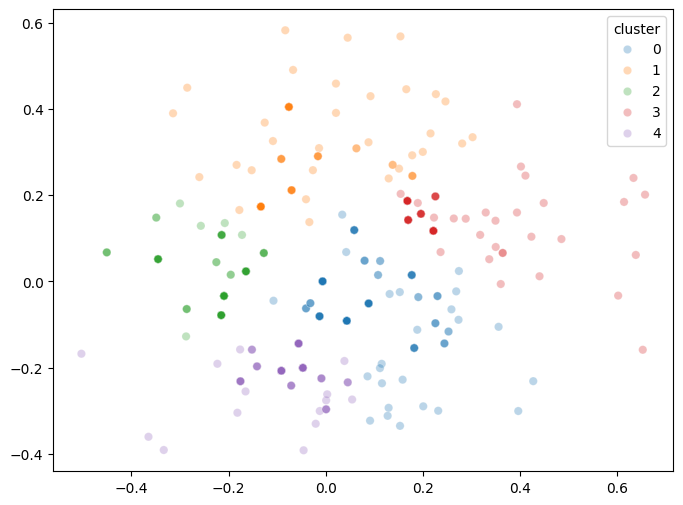

Intent detected: get_decomposition_space


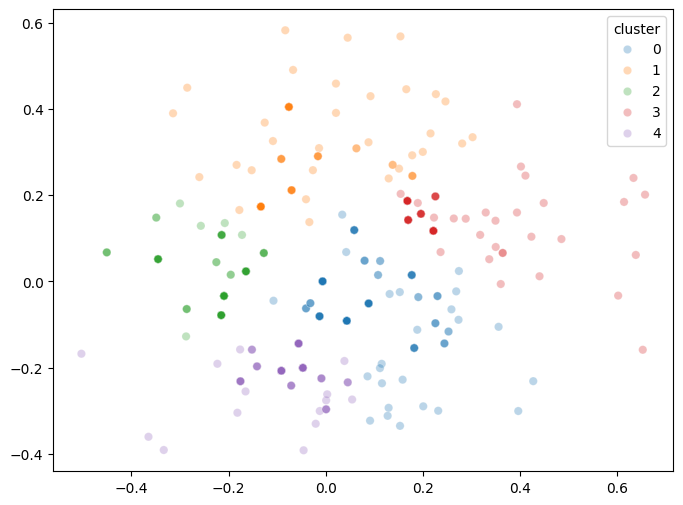

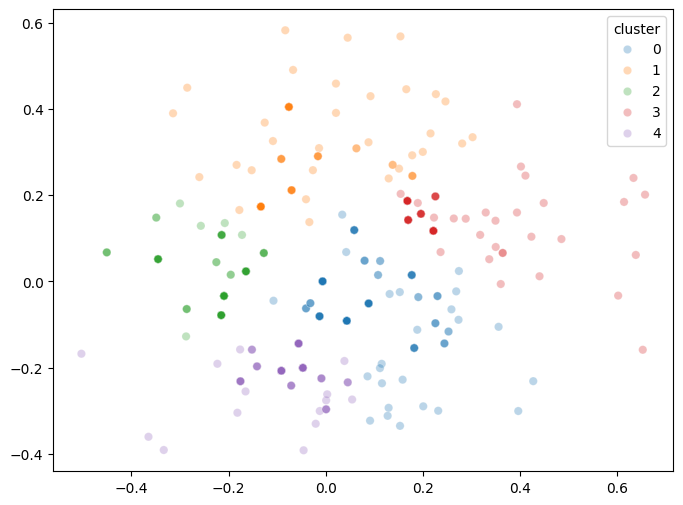

Intent detected: get_decomposition_space


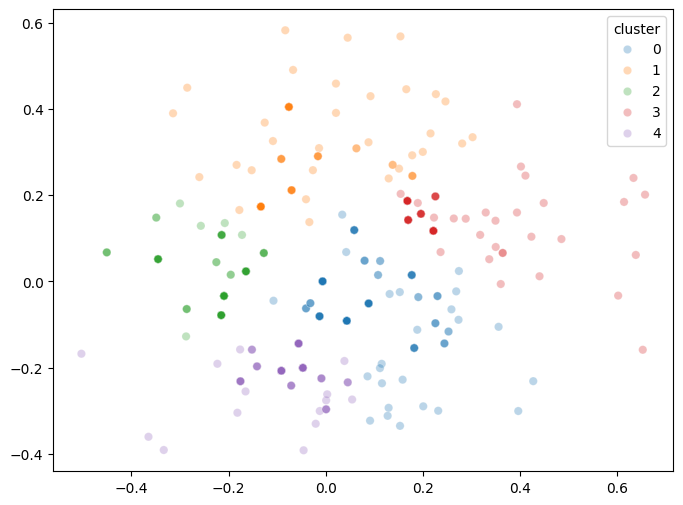

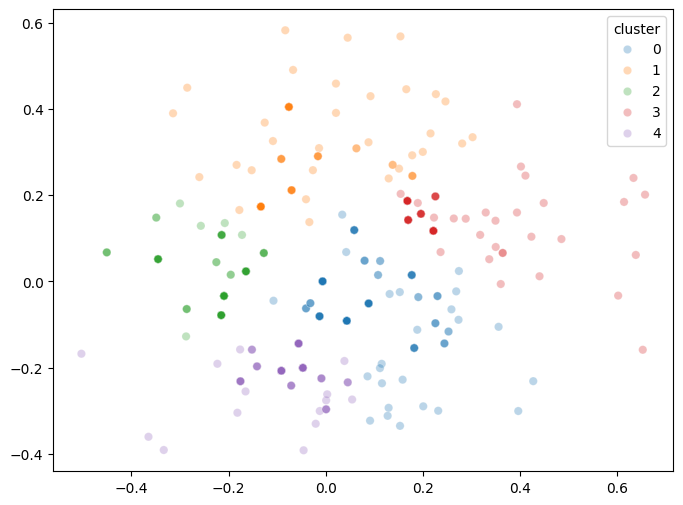

Intent detected: get_decomposition_space


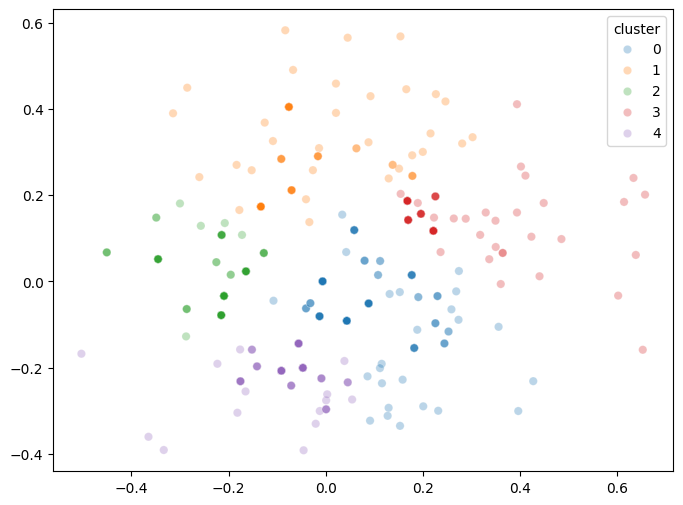

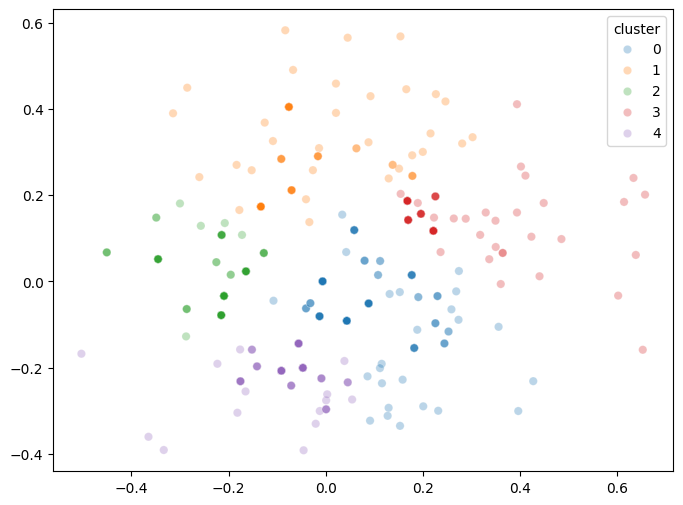

Intent detected: get_decomposition_space


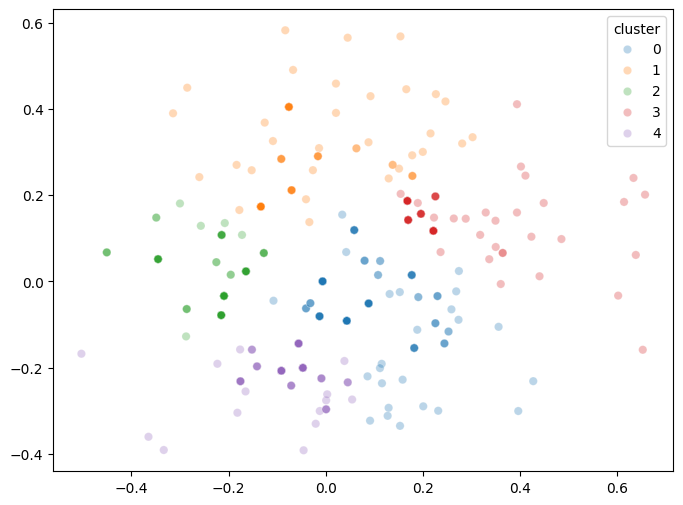

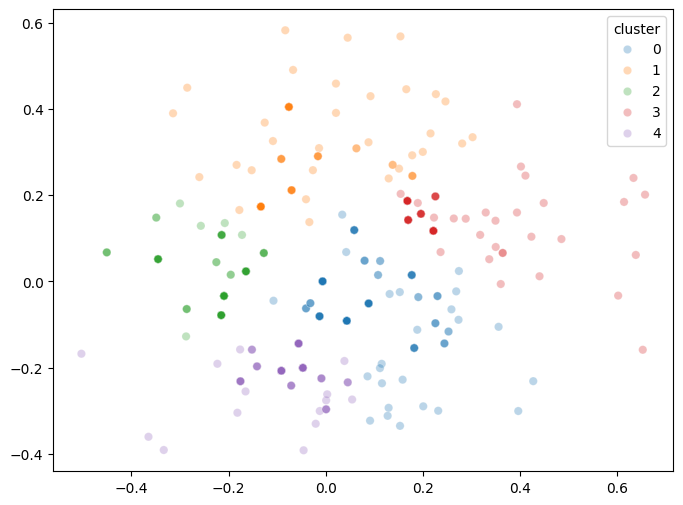

Intent detected: get_decomposition_space


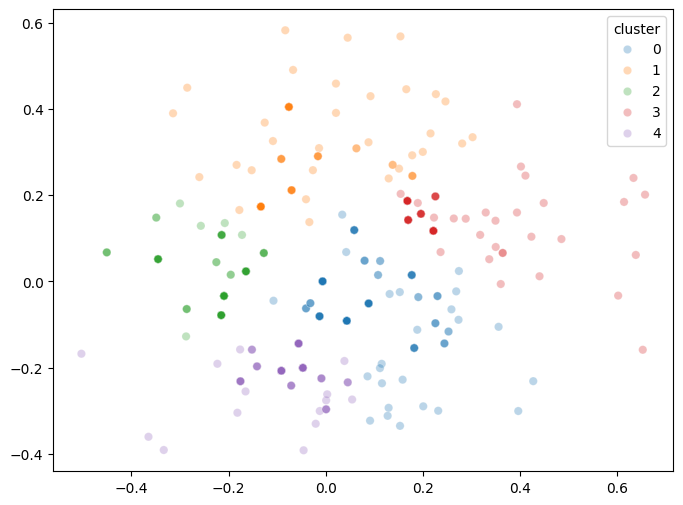

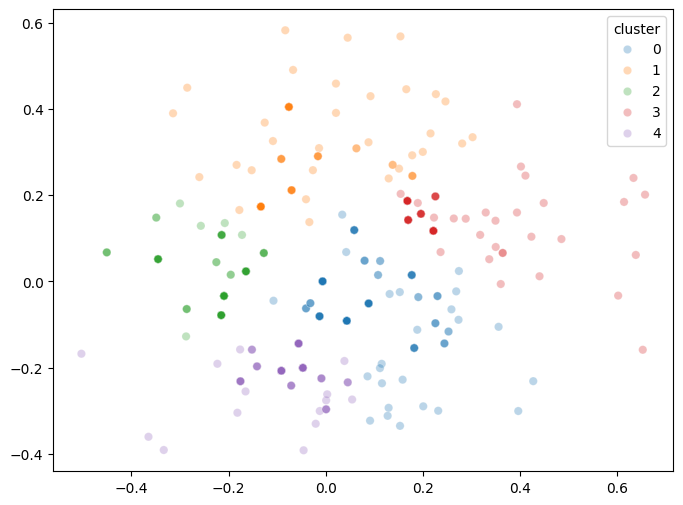

Intent detected: None
Intent detected: None
Intent detected: get_decomposition_space


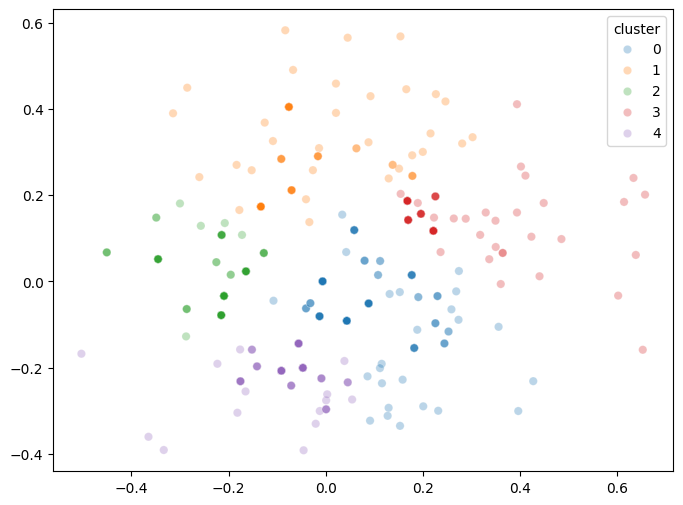

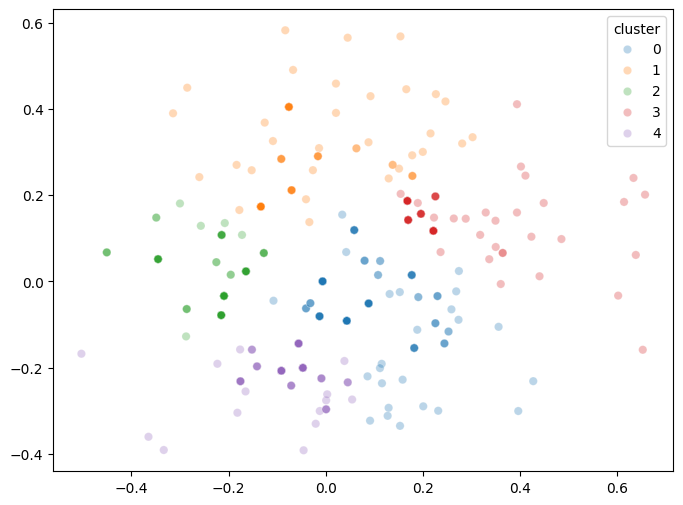

Intent detected: None
Intent detected: get_decomposition_space


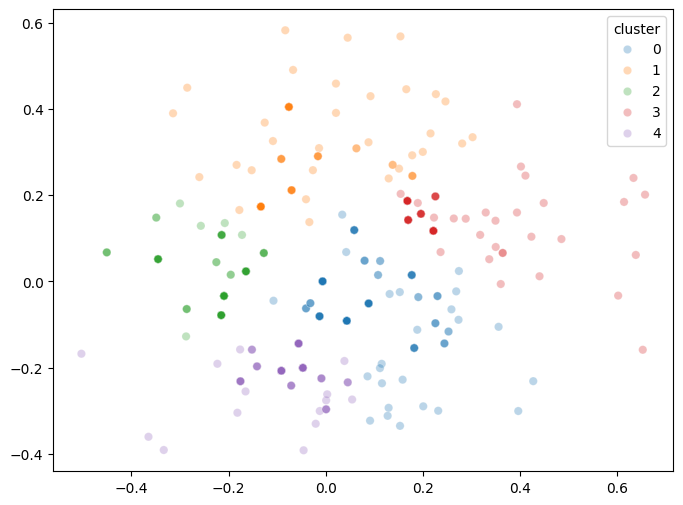

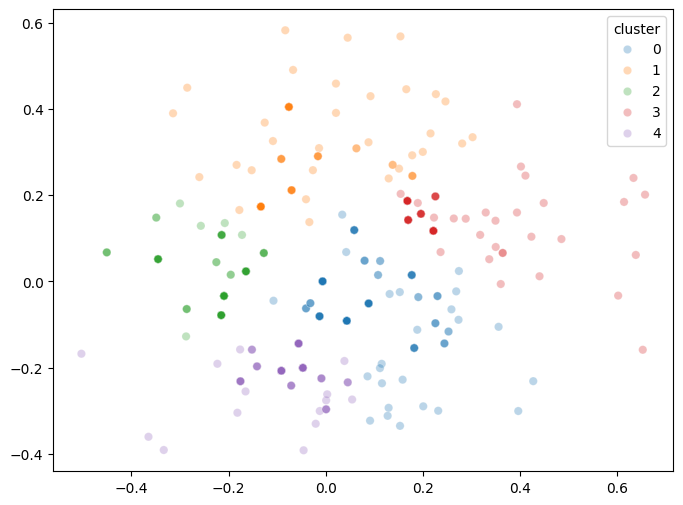

Intent detected: None
Intent detected: get_decomposition_by_metric


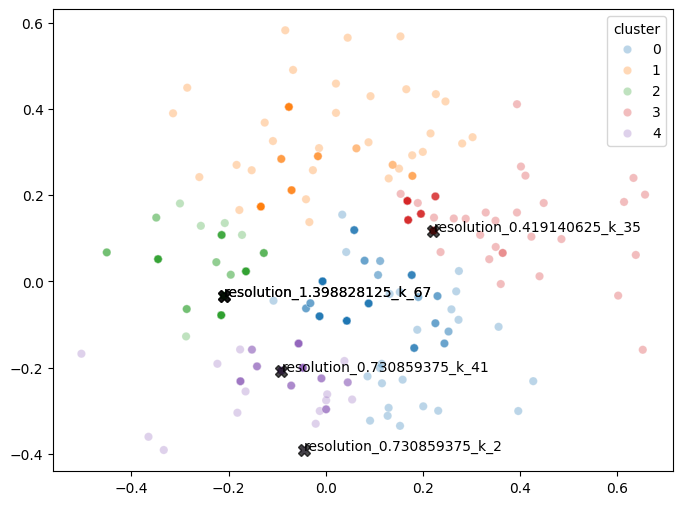

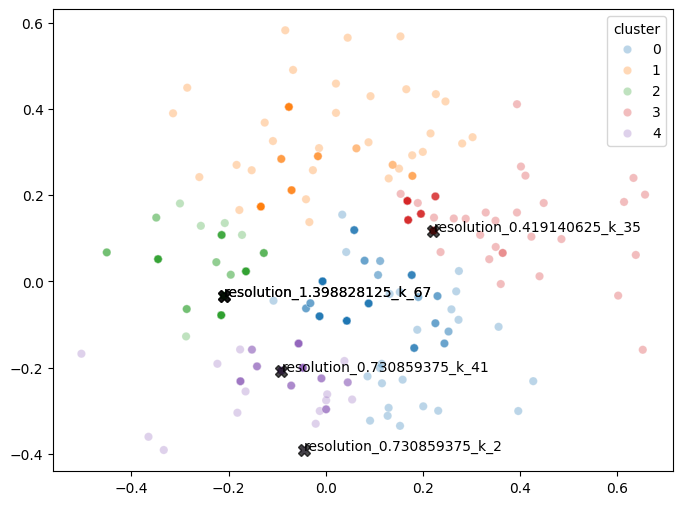

Intent detected: get_decomposition_by_metric


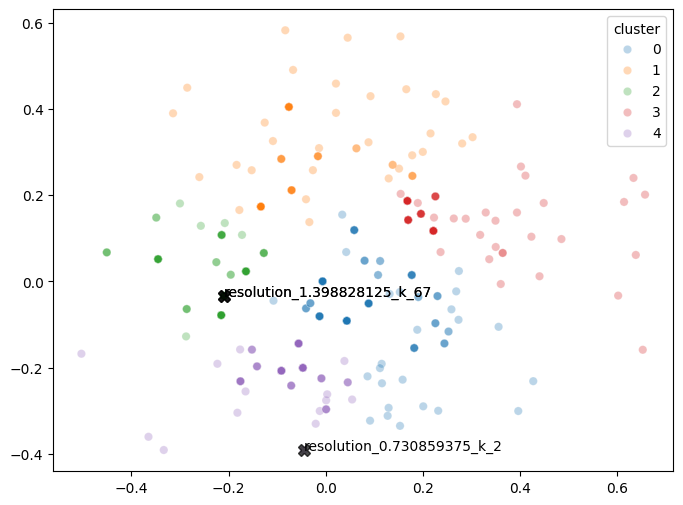

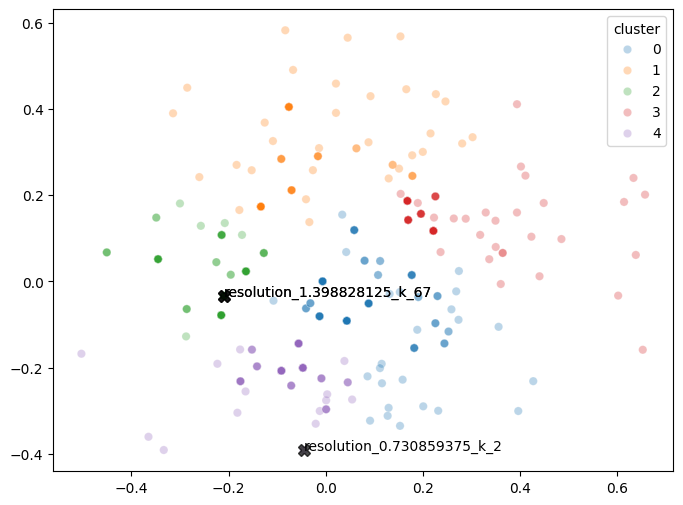

Intent detected: get_decomposition_by_metric
Intent detected: get_decomposition_space


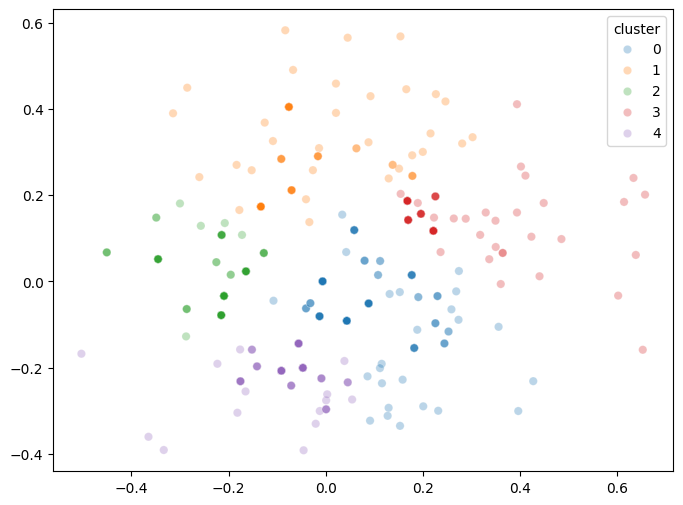

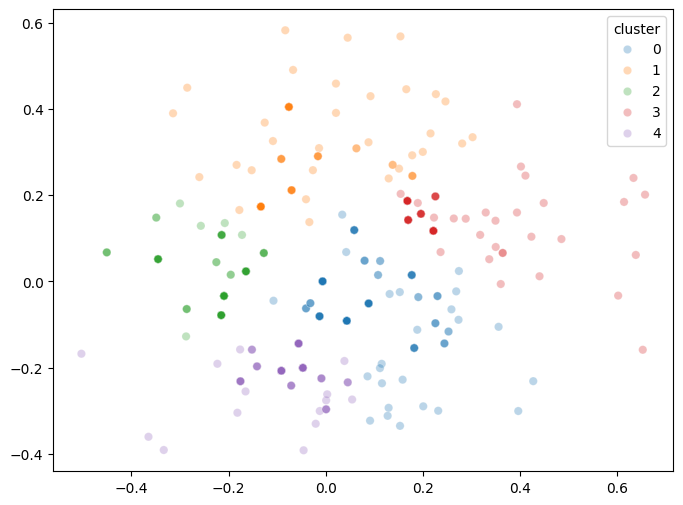

Intent detected: get_decomposition_by_metric
Intent detected: get_decomposition_space
Intent detected: get_decomposition_by_metric


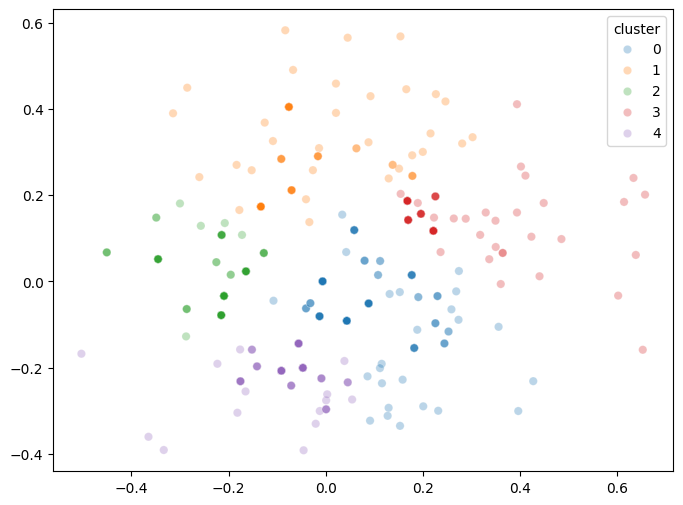

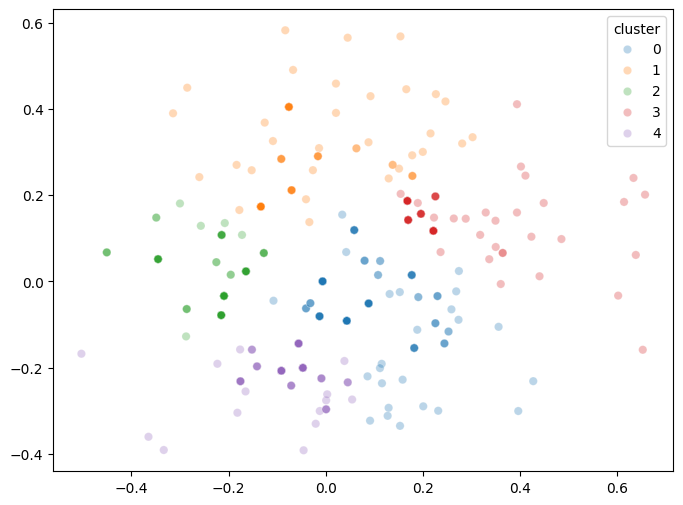

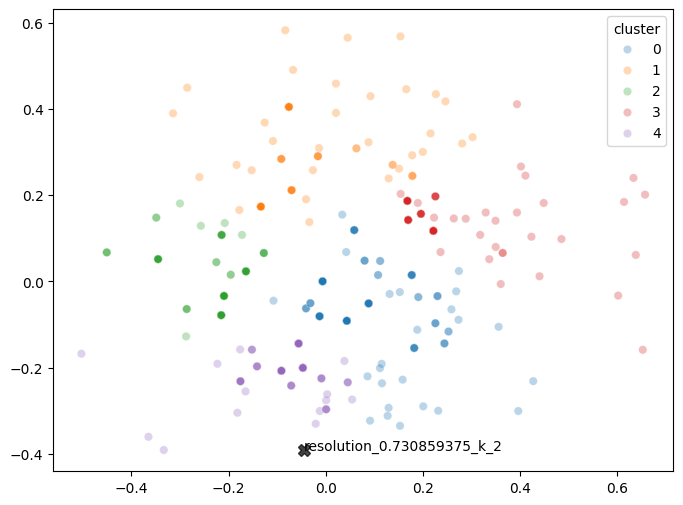

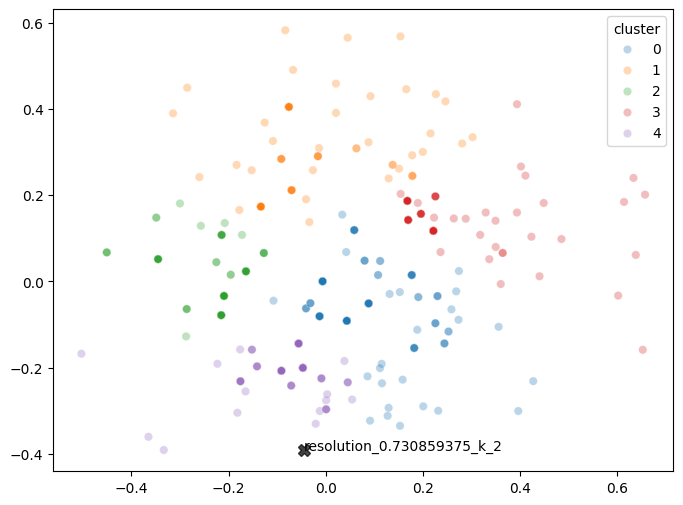

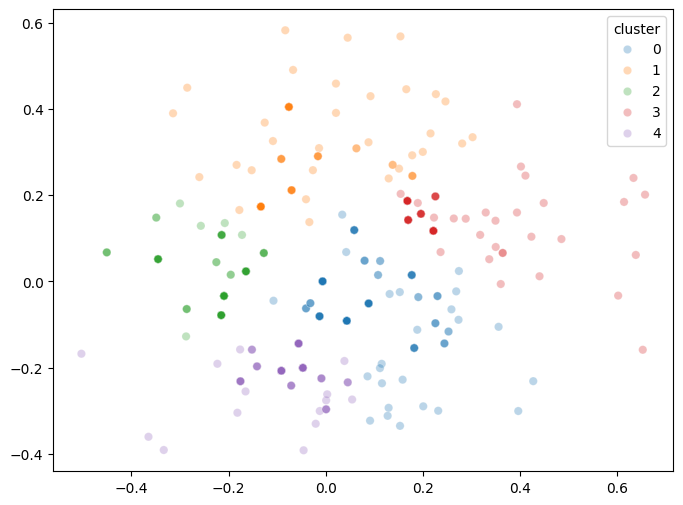

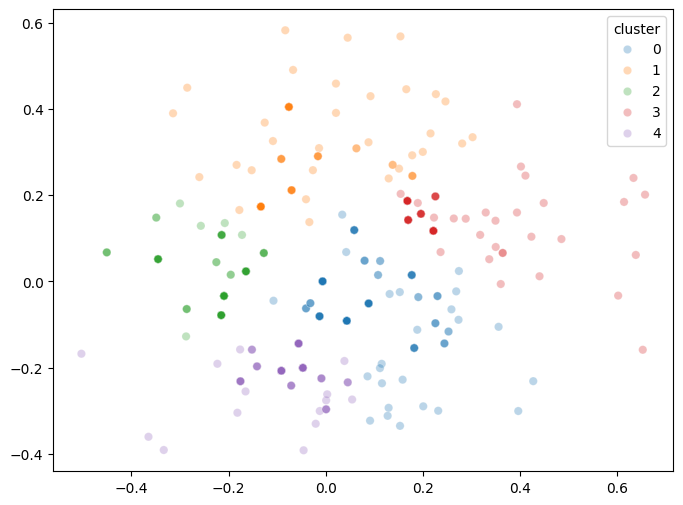

Intent detected: get_decomposition_space


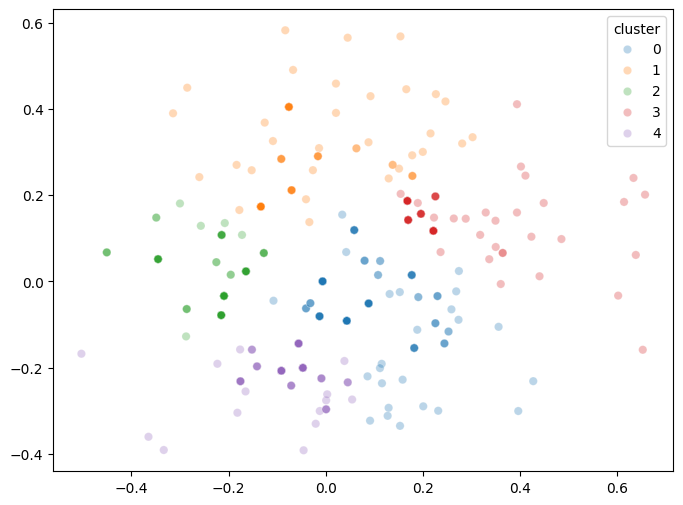

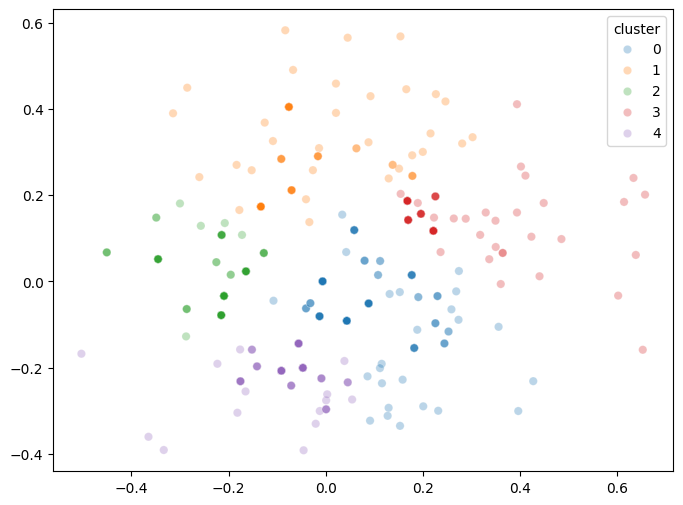

Intent detected: get_decomposition_space
Intent detected: get_decomposition_by_metric


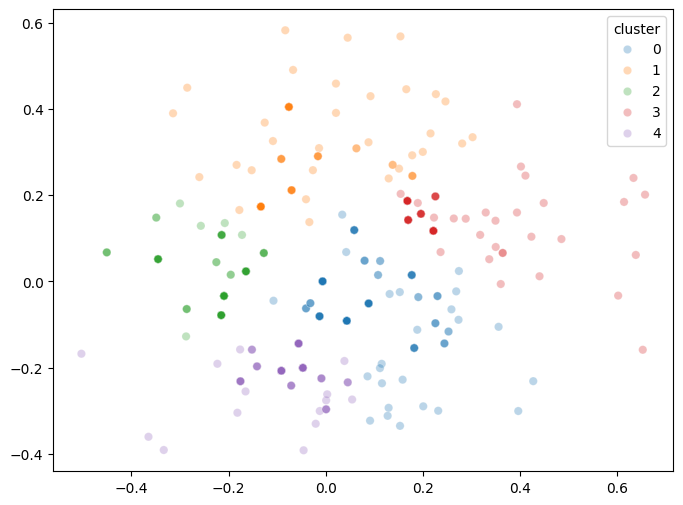

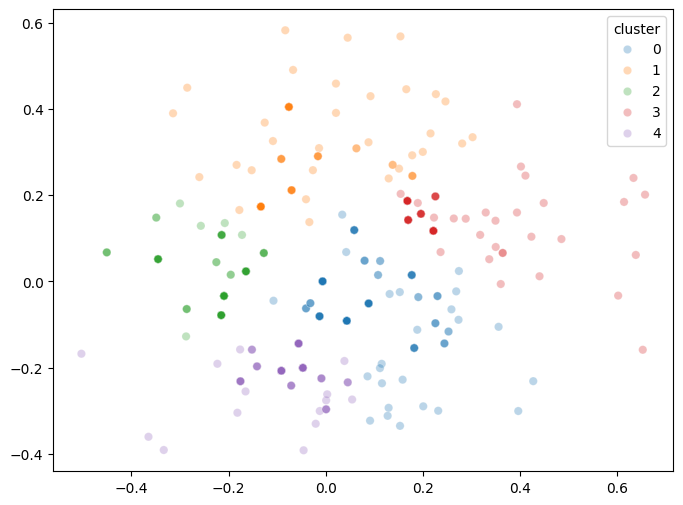

Intent detected: get_decomposition_space


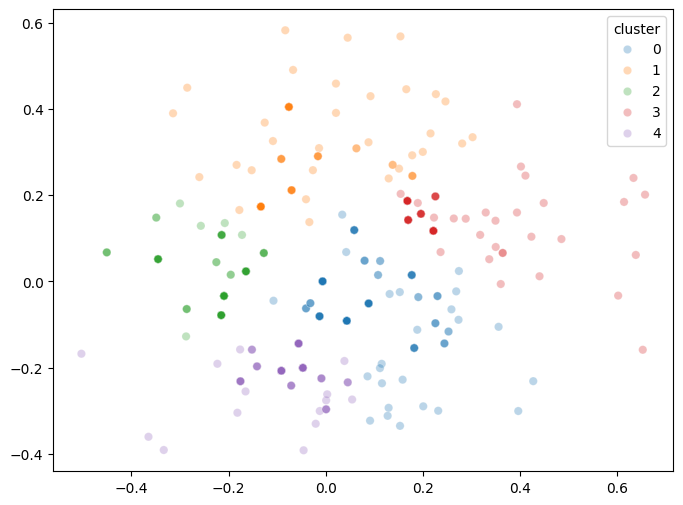

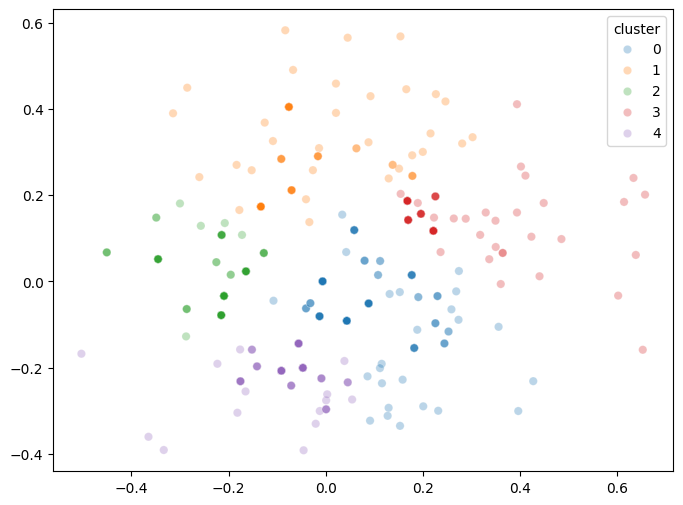

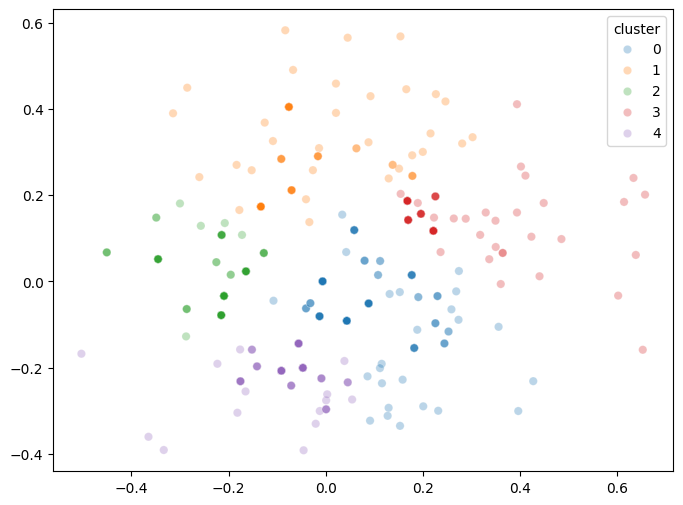

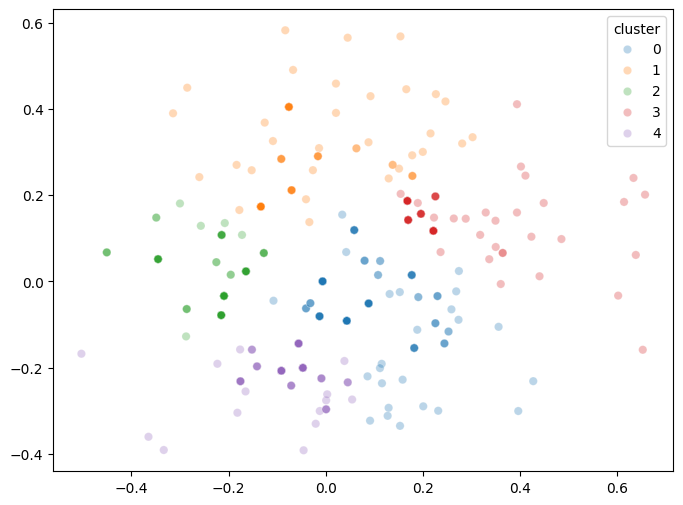

Intent detected: get_decomposition_by_metric
Intent detected: get_decomposition_by_metric


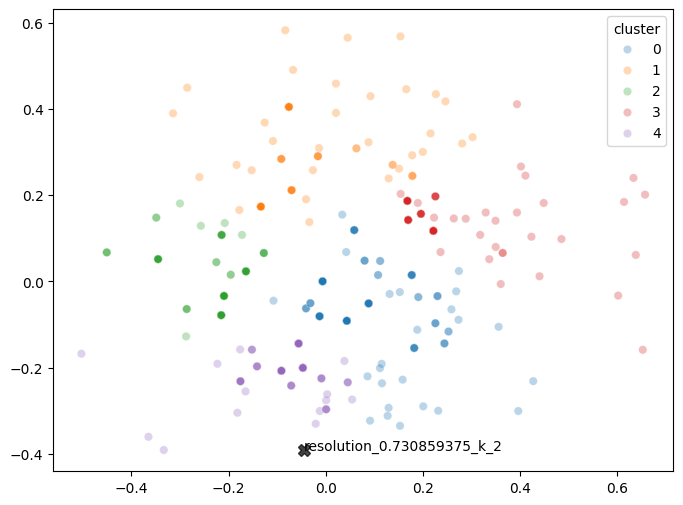

Intent detected: get_decomposition_space


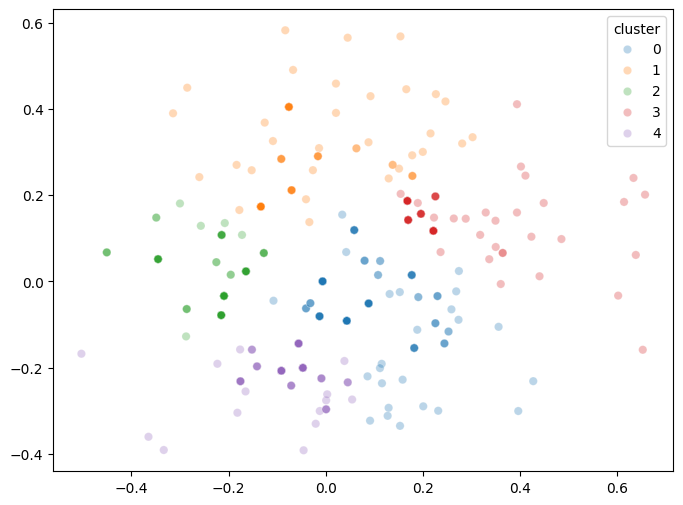

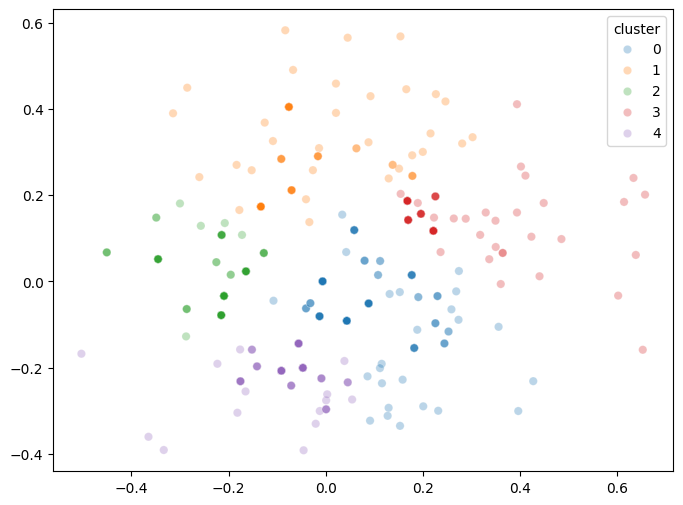

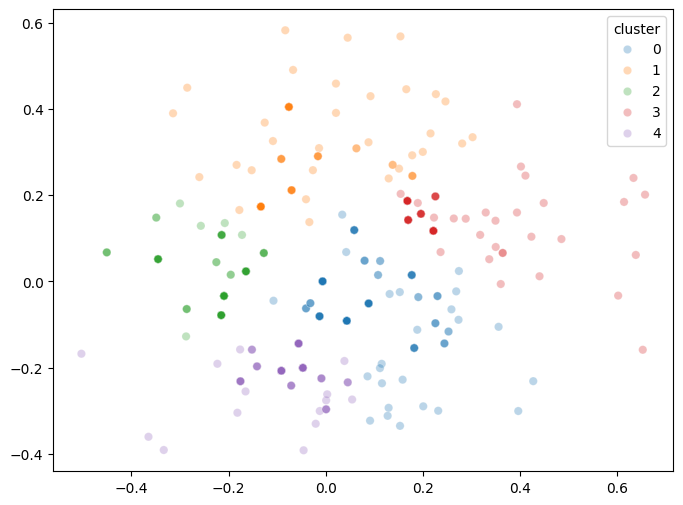

In [34]:
queries = []
responses = []
references = []

def pairwise(iterable):
    a = iter(iterable)
    return zip(a, a)

layer = SemanticLayer(decomposition_space)

for query, reference in pairwise(questions):
    try:
        response_vector, args, _ = layer.chat(query, return_intent=True)
        response = f"{response_vector}("
        response += ', '.join(f"{key}={value!r}" for key, value in args.items())
        response += ")"
        responses.append(response)
    except:
        responses.append("None")
    finally:
        queries.append(query)
        references.append(reference)
        layer.clear_memory()


In [35]:
from llama_index.core.evaluation import (
    CorrectnessEvaluator,
    SemanticSimilarityEvaluator
)

judges = {}
judges["correctness"] = CorrectnessEvaluator()
judges["semantic_similarity"] = SemanticSimilarityEvaluator()

In [36]:
import tqdm

evals = {
    "correctness": [],
    "semantic_similarity": []
}

for query, response, reference in tqdm.tqdm(
    zip(queries, responses, references)
):

    correctness_result = judges["correctness"].evaluate(
        query=query,
        response=response,
        reference=reference
    )

    semantic_similarity_result = judges["semantic_similarity"].evaluate(
        query=query,
        response=response,
        reference=reference,
    )

    evals["correctness"].append(correctness_result)
    evals["semantic_similarity"].append(semantic_similarity_result)

27it [00:18,  1.44it/s]


In [37]:
results = pd.DataFrame({
    'Queries': queries,
    'Answers': responses,
    'References': references,
    "Correctness score": list(map(lambda obj: obj.score, evals["correctness"])),
    "Correctness passing": list(map(lambda obj: obj.passing, evals["correctness"])),
    "Semantic similarity score": list(map(lambda obj: obj.score, evals["semantic_similarity"])),
    "Semantic similarity passing": list(map(lambda obj: obj.passing, evals["semantic_similarity"])),
})
results

,Queries,Answers,References,Correctness score,Correctness passing,Semantic similarity score,Semantic similarity passing
0,What is the decomposition space of a monolith ...,None,get_decomposition_space,1.0,False,0.542950,False
1,Can you show me the decomposition space graphi...,get_decomposition_space(),get_decomposition_space,4.0,True,0.983427,True
2,How many decompositions are generated in the d...,get_decomposition_space(),get_decomposition_space,4.0,True,0.983427,True
3,What does the decomposition space graph look l...,get_decomposition_space(),get_decomposition_space,4.0,True,0.983427,True
4,Can you provide a graphical representation of ...,get_decomposition_space(),get_decomposition_space,4.0,True,0.983427,True
5,What are the different decompositions in the d...,get_decomposition_space(),get_decomposition_space,4.0,True,0.983427,True
6,How can I visualize the decomposition space?,get_decomposition_space(),get_decomposition_space,4.0,True,0.983427,True
7,What is the purpose of the decomposition space...,None,get_decomposition_space,1.0,False,0.542950,False
8,How does the decomposition space help in under...,None,get_decomposition_space,1.0,False,0.542950,False
9,What are the key components of the decompositi...,get_decomposition_space(),get_decomposition_space,4.0,True,0.983427,True


In [38]:
results.to_csv(f"{PROJECT_PATH}/results.csv")

In [ ]:
responses
